<a href="https://colab.research.google.com/github/Khesorw/C-work/blob/master/final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center;">
  <h1 style="color: lightblue; font-size: 36px; animation: pulse 1s infinite;">
    FINAL PROJECT ADVANCED MACHINE LEARNING CODE

  </h1>
</div>

<style>
@keyframes pulse {
  0% { transform: scale(1); opacity: 1; }
  50% { transform: scale(1.1); opacity: 0.6; }
  100% { transform: scale(1); opacity: 1; }
}
</style>


## 0) Imports and Necessary Installations

### 0.1) Installation for Required Libraries

In [2]:
# !pip install -q kaggle
# !pip install kagglehub
# !pip install mlxtend
print("--" * 50)
print(f"All libraries successfully installed")

----------------------------------------------------------------------------------------------------
All libraries successfully installed


### 0.2) All imports for libraries for the project

In [3]:
import kagglehub
import os
import logging
import datetime
from pathlib import Path
from kagglehub import KaggleDatasetAdapter
from PIL import Image
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import layers, optimizers
from keras import callbacks
from keras.optimizers import Adam
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from keras.models import Sequential
import warnings
from sklearn.tree import DecisionTreeClassifier, plot_tree
warnings.filterwarnings("ignore")
import shutil
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Configure logging
def setup_logging():
    """Setup logging configuration for the project"""
    # Create logs directory if it doesn't exist
    log_dir = Path("Logs")
    log_dir.mkdir(exist_ok=True)

    # Create timestamp for log file
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = log_dir / f"aml_project_{timestamp}.log"

    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()  # Also log to console
        ]
    )

    # Create logger for this module
    logger = logging.getLogger('AML_Project')
    logger.info(f"Logging initialized. Log file: {log_file}")
    return logger

# Initialize logging
logger = setup_logging()

RANDOM_STATE = 2002
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:56<00:00, 99.1MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


## 1) Data Understanding


### 1.1) Collect Initial Data: Dataset Loading

In [5]:
# Shared Dataset Dir for Goolge Collab
dataset_dir = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2"

# Vasant's local computer vscode dataset set dir (Comment the line below and uncomment above for google colab)
# dataset_dir = "/home/vasant/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2"

def list_files_and_folders(startpath, level=0, processed_folders=None):
    """Lists files and folders in a directory up to a certain depth and limits image file listings, avoiding case-sensitive duplicates."""
    if processed_folders is None:
        processed_folders = set()

    if level >= 2:  # Limit the depth
        return

    for entry in os.listdir(startpath):
        full_path = os.path.join(startpath, entry)
        if os.path.isdir(full_path):
            # Check for case-insensitive duplicates
            if entry.lower() not in processed_folders:
                processed_folders.add(entry.lower())
                print("  " * level + f"[{entry}]")
                # Count and list image files in subfolder
                image_files_in_folder = [f for f in os.listdir(full_path) if f.endswith(".jpg")]
                print("  " * (level + 1) + f"Total images in [{entry}]: {len(image_files_in_folder)}")
                print("  " * (level + 1) + "First 5 image files:")
                for i, file in enumerate(image_files_in_folder[:5]):
                    print("  " * (level + 2) + file)
                list_files_and_folders(full_path, level + 1, processed_folders)
        else:
            # Only print non-image files at the top level
            if level == 0 and not entry.endswith(".jpg"):
                 print("  " * level + entry)

# List the directory structure of the dataset directory with a depth of 2, limiting image listings
list_files_and_folders(dataset_dir)

[ham10000_images_part_2]
  Total images in [ham10000_images_part_2]: 5015
  First 5 image files:
    ISIC_0030035.jpg
    ISIC_0033323.jpg
    ISIC_0033173.jpg
    ISIC_0029985.jpg
    ISIC_0031004.jpg
HAM10000_metadata.csv
[ham10000_images_part_1]
  Total images in [ham10000_images_part_1]: 5000
  First 5 image files:
    ISIC_0024380.jpg
    ISIC_0024646.jpg
    ISIC_0024804.jpg
    ISIC_0026552.jpg
    ISIC_0026063.jpg
hmnist_28_28_RGB.csv
hmnist_28_28_L.csv
hmnist_8_8_RGB.csv
hmnist_8_8_L.csv


In [8]:
import shutil
import os

# Destination folder in Colab's persistent working area
target_dir = "/content/ham10000"
os.makedirs(target_dir, exist_ok=True)

# Copy metadata CSV
shutil.copy(
    os.path.join(dataset_dir, "HAM10000_metadata.csv"),
    os.path.join(target_dir, "HAM10000_metadata.csv")
)

# Copy image files
image_src_dir = os.path.join(dataset_dir, "HAM10000_images_part_1")
image_dst_dir = os.path.join(target_dir, "images")
os.makedirs(image_dst_dir, exist_ok=True)

# Copy both parts of the image folder (part_1 and part_2)
for part in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
    part_dir = os.path.join(dataset_dir, part)
    for fname in os.listdir(part_dir):
        if fname.endswith(".jpg"):
            shutil.copy(os.path.join(part_dir, fname), image_dst_dir)


In [9]:
# Check if metadata and images exist
import pandas as pd

metadata_path = os.path.join(target_dir, "HAM10000_metadata.csv")
df = pd.read_csv(metadata_path)

print("Total records in metadata:", len(df))
print("Sample image file:", os.listdir(image_dst_dir)[:5])



Total records in metadata: 10015
Sample image file: ['ISIC_0030035.jpg', 'ISIC_0033323.jpg', 'ISIC_0024380.jpg', 'ISIC_0033173.jpg', 'ISIC_0024646.jpg']


In [13]:
# Path to combined image directory
image_folder = "/content/ham10000/images"

# Count .jpg files
image_count = len([f for f in os.listdir(image_folder) if f.endswith(".jpg")])
print(f"🧾 Total images in '{image_folder}': {image_count}")


🧾 Total images in '/content/ham10000/images': 10015


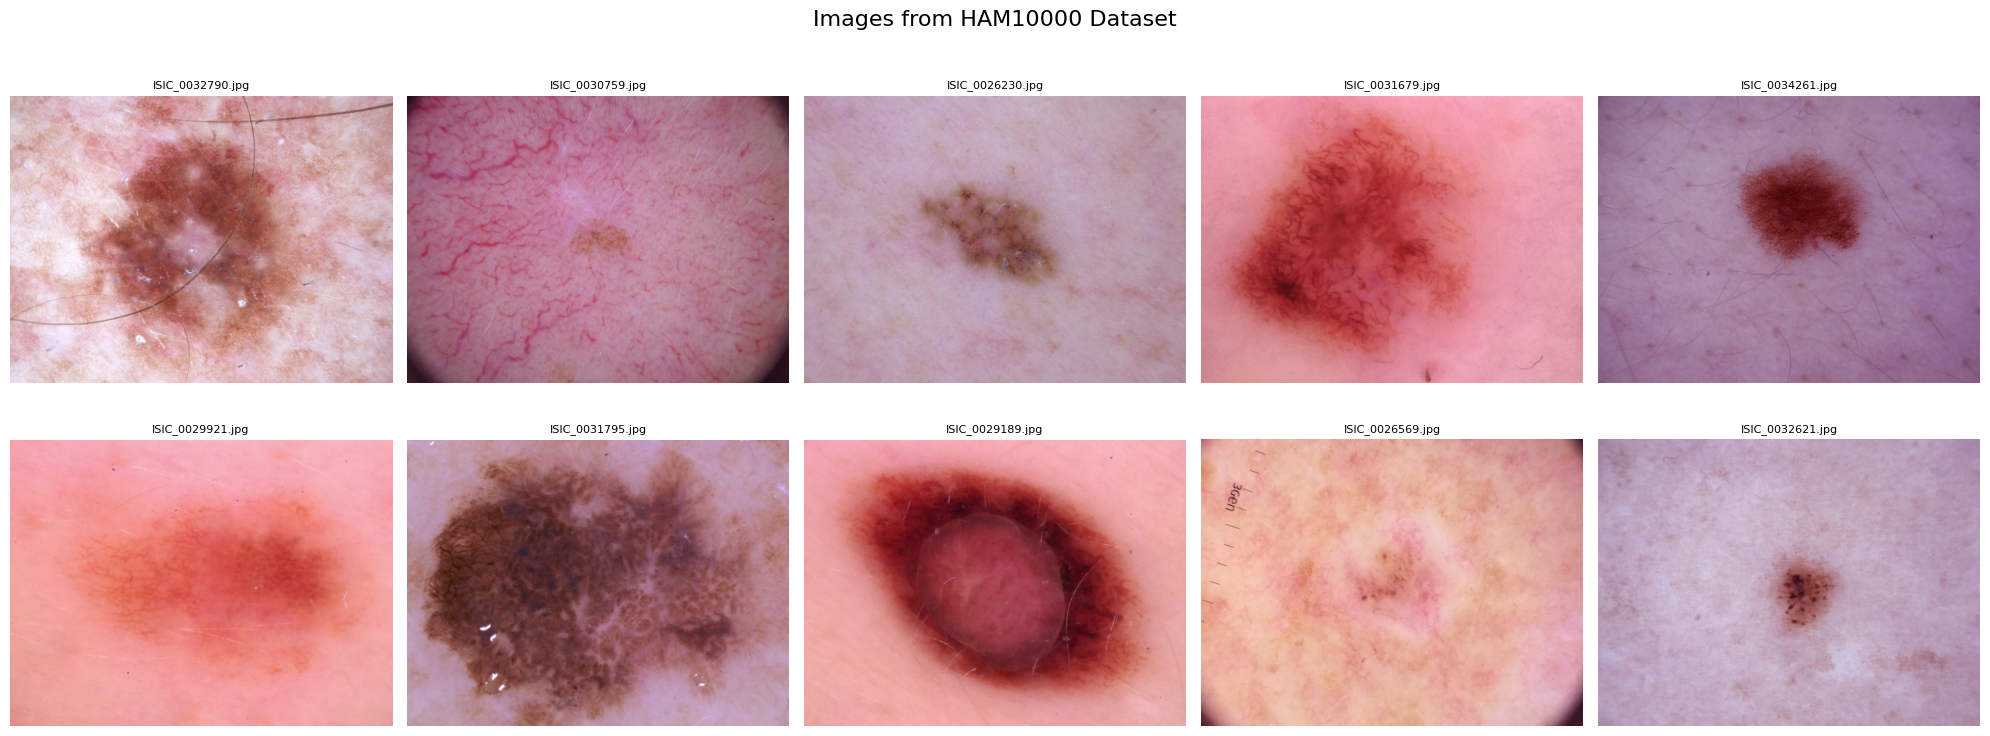

In [17]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path to image directories (adjust if you copied to /content/)
image_dirs = ['/content/ham10000/images']

# Collect all image paths
all_image_paths = []
for dir_path in image_dirs:
    all_image_paths += [os.path.join(dir_path, fname) for fname in os.listdir(dir_path) if fname.endswith('.jpg')]

# Randomly choose 10 image paths
random_image_paths = random.sample(all_image_paths, 10)

# Plot the images
plt.figure(figsize=(20, 8))
for i, img_path in enumerate(random_image_paths):
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=8)
    plt.axis('off')

plt.suptitle("Images from HAM10000 Dataset", fontsize=16)
plt.tight_layout()
plt.show()


In [27]:
print(all_image_paths[:3])

['/content/ham10000/images/ISIC_0030035.jpg', '/content/ham10000/images/ISIC_0033323.jpg', '/content/ham10000/images/ISIC_0024380.jpg']


### 1.2) Describe Data

In [37]:
# pip install kagglehub[pandas-datasets]
# Set the path to the CSV file in the dataset
# file_path = "HAM10000_metadata.csv"

# # Load the dataset as a DataFrame
# orig_df = kagglehub.load_dataset(
#     KaggleDatasetAdapter.PANDAS,
#     "kmader/skin-cancer-mnist-ham10000",
#     file_path
# )

metaData = pd.read_csv('/content/ham10000/HAM10000_metadata.csv',index_col=1)

print(metaData.head(5))

# # Declare index as image_id
# orig_df_with_index = orig_df.set_index("image_id")
# orig_df_with_index = orig_df_with_index.sort_index()
# print(orig_df_with_index.head(10))

                lesion_id   dx dx_type   age   sex localization
image_id                                                       
ISIC_0027419  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0025030  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0026769  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0025661  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0031633  HAM_0001466  bkl   histo  75.0  male          ear


In [38]:
metaData = metaData.sort_index(ascending=True)
print(metaData.head(5))

                lesion_id   dx    dx_type   age     sex     localization
image_id                                                                
ISIC_0024306  HAM_0000550   nv  follow_up  45.0    male            trunk
ISIC_0024307  HAM_0003577   nv  follow_up  50.0    male  lower extremity
ISIC_0024308  HAM_0001477   nv  follow_up  55.0  female            trunk
ISIC_0024309  HAM_0000484   nv  follow_up  40.0    male            trunk
ISIC_0024310  HAM_0003350  mel      histo  60.0    male            chest


In [56]:
# # # Dataset Preparation Code
# # Metadata CSV
# metadata_path = os.path.join(base_path, "HAM10000_metadata.csv")
# df = pd.read_csv(metadata_path)
# # Target output folder
# output_dir = "/kaggle/working/HAM10000_images_by_class"
# os.makedirs(output_dir, exist_ok=True)

# # Map image_id to dx (diagnosis/class)
# image_to_class = dict(zip(df['image_id'], df['dx']))

# # Combined image folder paths
# image_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]

# # Loop through both folders and copy images to class subfolders
# for folder in image_dirs:
#     folder_path = os.path.join(base_path, folder)
#     for fname in os.listdir(folder_path):
#         if fname.endswith(".jpg"):
#             image_id = fname.replace(".jpg", "")
#             if image_id in image_to_class:
#                 class_name = image_to_class[image_id]
#                 class_dir = os.path.join(output_dir, class_name)
#                 os.makedirs(class_dir, exist_ok=True)

#                 src_path = os.path.join(folder_path, fname)
#                 dst_path = os.path.join(class_dir, fname)

#                 # Copy image to class folder
#                 shutil.copyfile(src_path, dst_path)

# print("✅ All images copied and organized by class.")

In [39]:
print(metaData.info())


print("Missing age values:", metaData['age'].isnull().sum())

metaData = metaData.dropna(subset=['age'])
print(metaData.info())

print("count of each category of dx :",metaData['dx'].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 10015 entries, ISIC_0024306 to ISIC_0034320
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   dx            10015 non-null  object 
 2   dx_type       10015 non-null  object 
 3   age           9958 non-null   float64
 4   sex           10015 non-null  object 
 5   localization  10015 non-null  object 
dtypes: float64(1), object(5)
memory usage: 547.7+ KB
None
Missing age values: 57
<class 'pandas.core.frame.DataFrame'>
Index: 9958 entries, ISIC_0024306 to ISIC_0034320
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     9958 non-null   object 
 1   dx            9958 non-null   object 
 2   dx_type       9958 non-null   object 
 3   age           9958 non-null   float64
 4   sex           9958 non-null   object 
 5   localization  9958 non-null

Total duplicate entries (not dropped): 4489


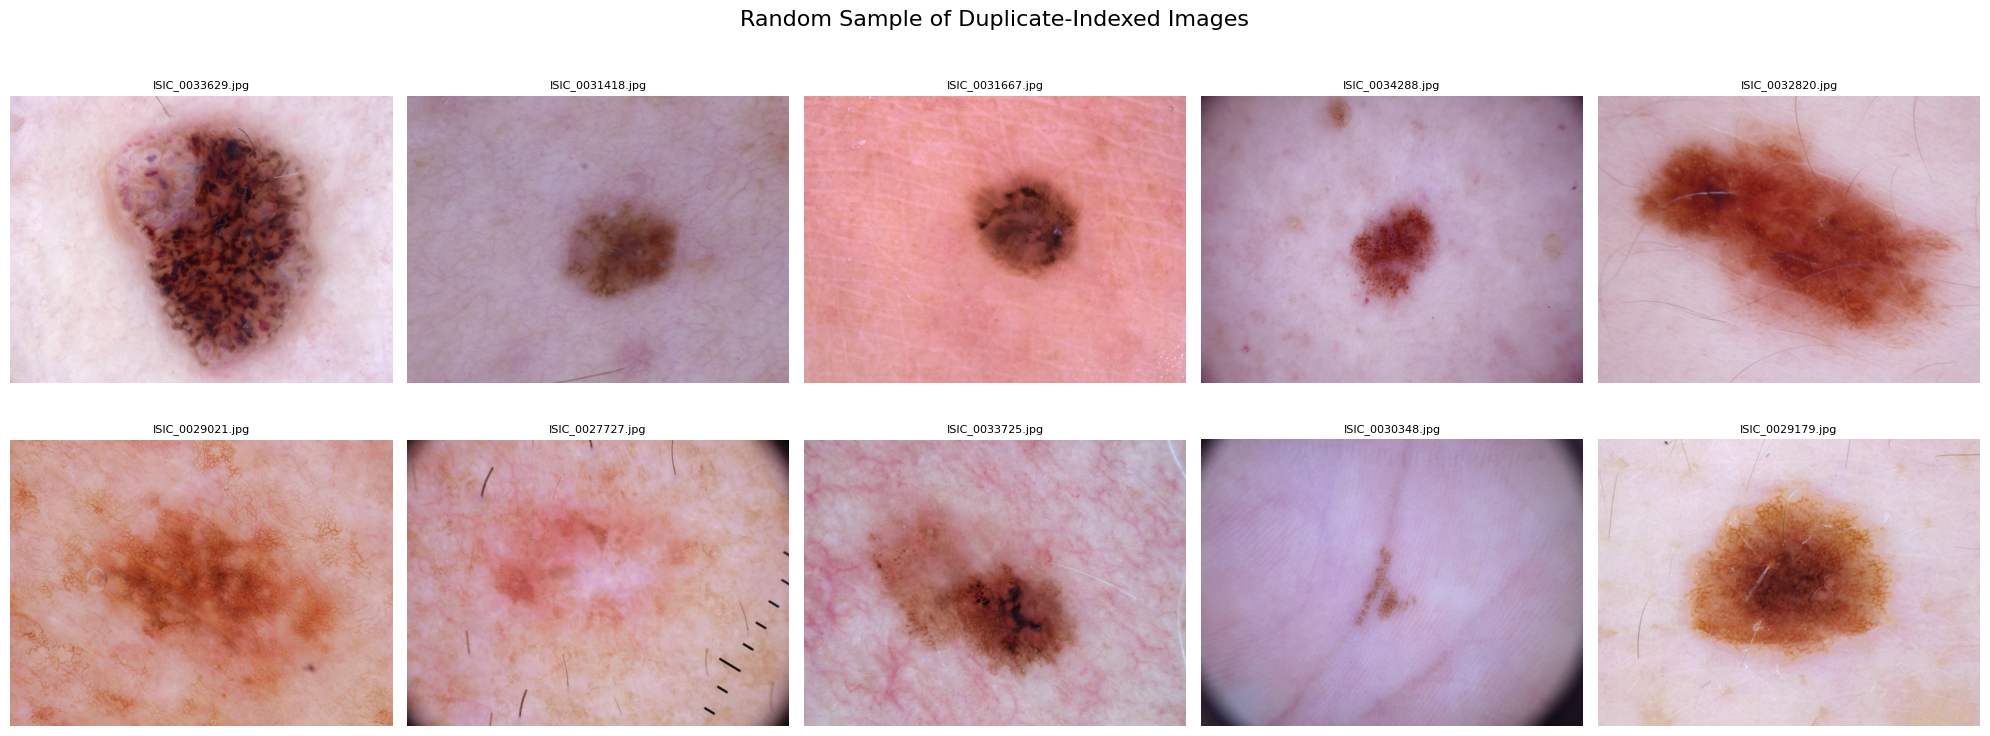

In [40]:
#Verify if dup rows are actually duplicate images

# Step 1: Identify duplicate rows (based on full row comparison)
duplicates_mask = metaData.duplicated(keep=False)

# Step 2: Extract duplicates into a separate DataFrame
duplicates_df = metaData[duplicates_mask]

print(f"Total duplicate entries (not dropped): {len(duplicates_df)}")

# Step 3: Get image paths for those duplicates
duplicate_image_ids = duplicates_df.index.tolist()

# Path to the images folder
image_folder = "/content/ham10000/images"

# Build full image paths
duplicate_image_paths = [os.path.join(image_folder, f"{img_id}.jpg") for img_id in duplicate_image_ids]

# Step 4: Randomly select 10 images from duplicates
random_duplicate_paths = random.sample(duplicate_image_paths, 10)

# Step 5: Display images
plt.figure(figsize=(20, 8))
for i, img_path in enumerate(random_duplicate_paths):
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=8)
    plt.axis('off')

plt.suptitle("Random Sample of Duplicate-Indexed Images", fontsize=16)
plt.tight_layout()
plt.show()


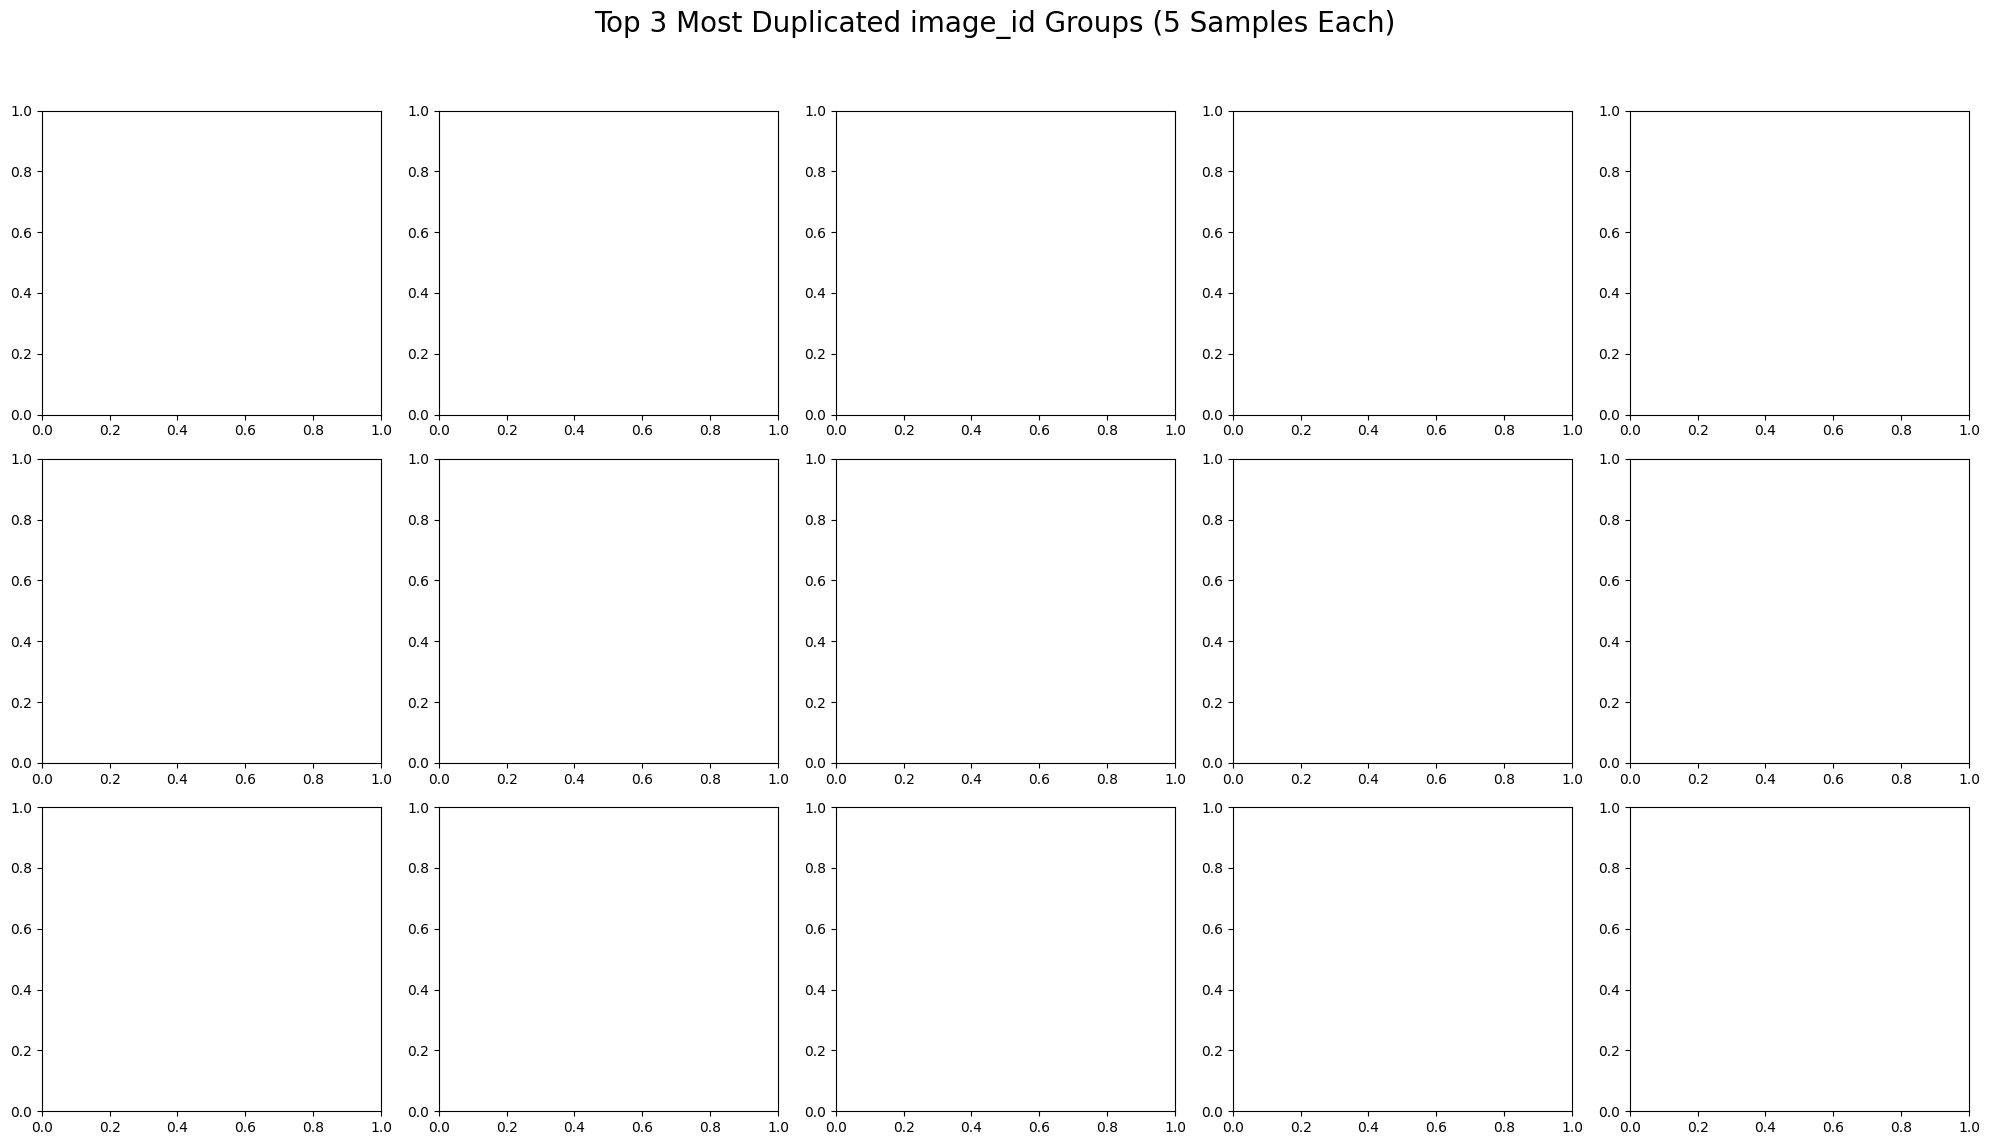

In [44]:
# Directory where your images are stored
image_folder = '/content/ham10000/images'

# Step 1: Get all duplicated rows (based on index `image_id`)
duplicate_df = metaData[metaData.index.duplicated(keep=False)]

# Step 2: Count duplicates by index (image_id)
dup_counts = duplicate_df.index.value_counts()

# Step 3: Get top 3 most duplicated image_ids
top_duplicates = dup_counts.head(3).index.tolist()

# Step 4: Create a 3x5 subplot
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
fig.suptitle('Top 3 Most Duplicated image_id Groups (5 Samples Each)', fontsize=20)

# Step 5: Loop through top 3 and display images
for row_idx, image_id in enumerate(top_duplicates):
    # Get all duplicate rows for this image_id
    matching_rows = duplicate_df.loc[image_id]

    # If only one row (not multiple duplicates), make it a DataFrame
    if isinstance(matching_rows, pd.Series):
        matching_rows = matching_rows.to_frame().T

    # Sample up to 5 records (in case there are fewer)
    sample_ids = matching_rows.sample(n=min(5, len(matching_rows)), random_state=42).index.tolist()

    for col_idx, img_id in enumerate(sample_ids):
        ax = axs[row_idx, col_idx]
        image_path = os.path.join(image_folder, f"{img_id}.jpg")

        try:
            img = Image.open(image_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"{img_id}", fontsize=9)
        except Exception as e:
            ax.text(0.5, 0.5, 'Error', ha='center', va='center')
            ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [48]:
# Find duplicate rows (ignoring index)
duplicates_mask = metaData.duplicated(keep=False)  # keep=False marks all duplicates True, including first occurrences

# Extract all duplicate rows (including the first)
duplicate_rows = metaData[duplicates_mask]

print(f"Total duplicate rows (including first occurrences): {len(duplicate_rows)}")

# How many unique duplicated groups (unique rows that are duplicated)
num_unique_duplicate_groups = duplicate_rows.drop_duplicates().shape[0]
print(f"Unique duplicate groups: {num_unique_duplicate_groups}")

# Show some example duplicate rows (first 5)
print(duplicate_rows.head())

# Get counts of each duplicated row to understand frequency
duplicate_group_counts = duplicate_rows.groupby(list(metaData.columns)).size().sort_values(ascending=False)
print(duplicate_group_counts.head())


Total duplicate rows (including first occurrences): 4489
Unique duplicate groups: 1951
                lesion_id   dx dx_type   age     sex     localization
image_id                                                             
ISIC_0024310  HAM_0003350  mel   histo  60.0    male            chest
ISIC_0024312  HAM_0001359  bkl   histo  75.0    male  lower extremity
ISIC_0024313  HAM_0002869  mel   histo  50.0  female             back
ISIC_0024314  HAM_0002198   nv   histo  75.0    male  lower extremity
ISIC_0024315  HAM_0007538  mel   histo  55.0    male            trunk
lesion_id    dx   dx_type    age   sex     localization   
HAM_0001863  mel  histo      70.0  male    upper extremity    6
HAM_0005263  nv   consensus  40.0  male    trunk              6
HAM_0003789  bkl  confocal   55.0  female  face               6
HAM_0000835  bkl  confocal   55.0  female  face               6
HAM_0007343  mel  histo      70.0  male    chest              5
dtype: int64


In [62]:
#sort the duplicate rows in asc
print(len(duplicate_group_counts))
print(len(duplicate_rows))
duplicate_group_counts.sort_values(ascending=True,inplace=True)
print(duplicate_group_counts.head(10))


print('#'*100)
print("now highest occurance of duplicate")
#dup row desc the highest count
duplicate_group_counts.sort_values(ascending=False,inplace=True)
print(duplicate_group_counts.head(10))

1951
4489
lesion_id    dx   dx_type    age   sex     localization   
HAM_0006423  mel  histo      55.0  male    back               2
HAM_0006426  mel  histo      80.0  female  upper extremity    2
HAM_0006430  nv   histo      20.0  female  back               2
HAM_0006433  mel  histo      85.0  female  upper extremity    2
HAM_0007163  mel  histo      50.0  female  lower extremity    2
HAM_0007350  nv   histo      45.0  male    back               2
HAM_0000395  nv   histo      40.0  male    upper extremity    2
HAM_0006457  nv   histo      40.0  male    lower extremity    2
HAM_0006458  nv   histo      80.0  male    back               2
HAM_0006913  nv   consensus  65.0  male    upper extremity    2
dtype: int64
####################################################################################################
now highest occurance of duplicate
lesion_id    dx   dx_type    age   sex     localization   
HAM_0003789  bkl  confocal   55.0  female  face               6
HAM_0000835  bkl  c

In [64]:

frequency_distribution = duplicate_group_counts.value_counts().sort_index()

print("📊 Frequency distribution of duplicate group sizes:")
print(frequency_distribution)


📊 Frequency distribution of duplicate group sizes:
2    1420
3     488
4      34
5       5
6       4
Name: count, dtype: int64


the highest number of time a row has occured is 6 and min is 2

lesion_id
HAM_0001863    6
HAM_0005263    6
dtype: int64


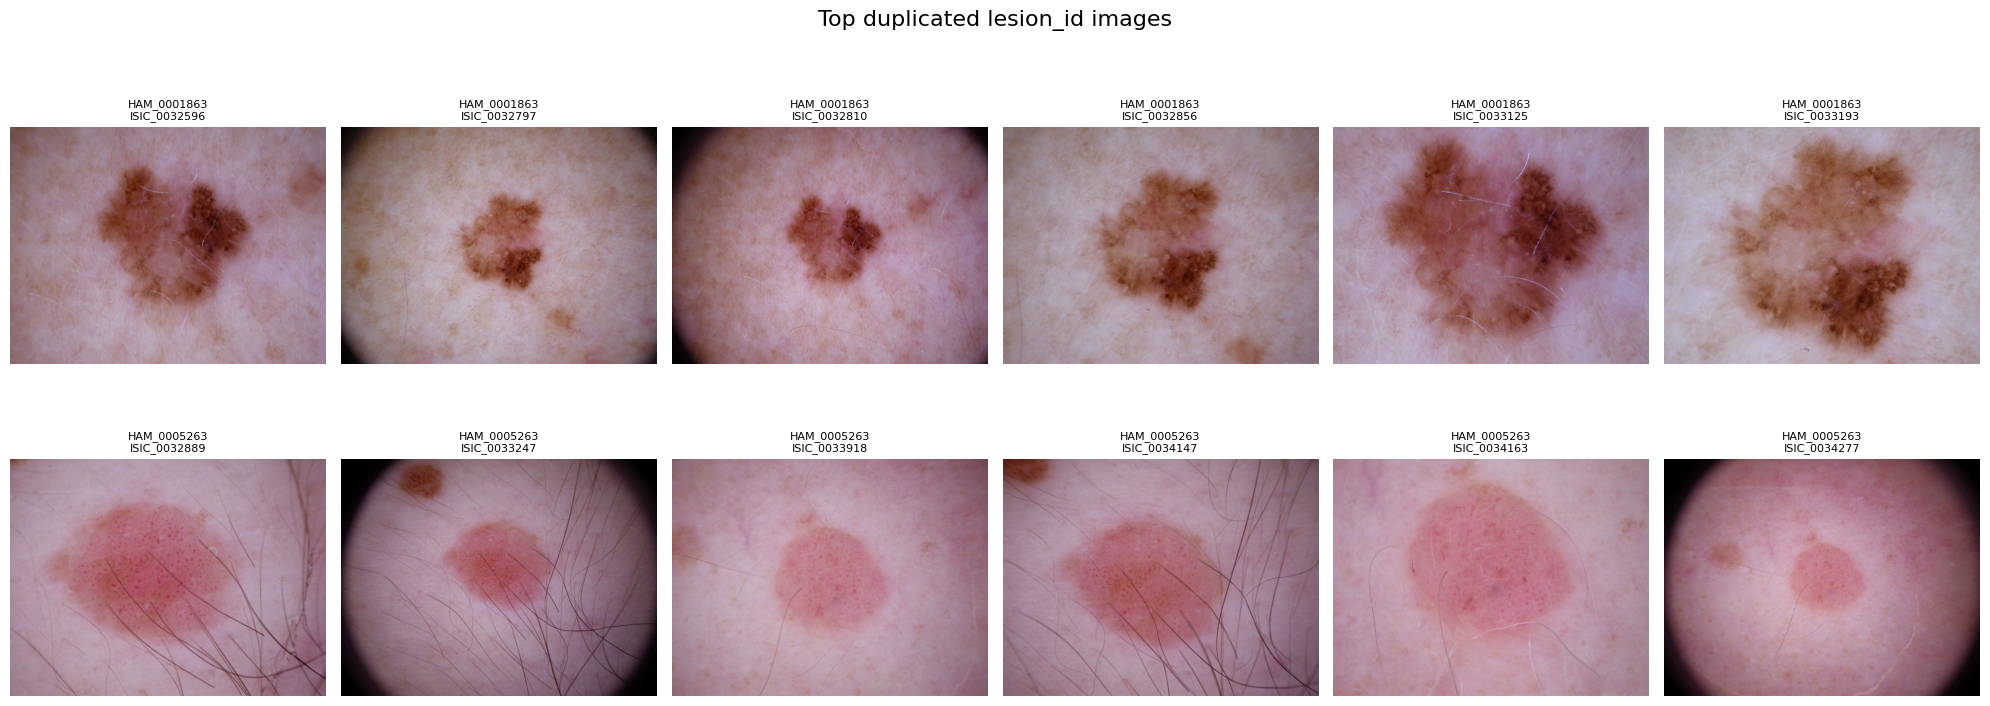

In [49]:
#verify duplicate records with their correspondance images


# 1. Group metadata by lesion_id and count how many images per lesion_id
lesion_counts = metaData.groupby('lesion_id').size().sort_values(ascending=False)

# 2. Take top 2 lesion_ids as example (you can change how many)
top_lesions = lesion_counts.head(2)

print(top_lesions)

# 3. Prepare to plot images per lesion_id
image_folder = '/content/ham10000/images'  # adjust path if needed

plt.figure(figsize=(20, 8))

row_num = 1
for lesion_id, count in top_lesions.items():
    # Find all image_ids with this lesion_id
    image_ids_for_lesion = metaData[metaData['lesion_id'] == lesion_id].index.tolist()

    # Limit the images to the count (should match anyway)
    image_ids_for_lesion = image_ids_for_lesion[:count]

    # Plot images for this lesion in one row
    for i, image_id in enumerate(image_ids_for_lesion):
        img_path = os.path.join(image_folder, f"{image_id}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(len(top_lesions), max(top_lesions), (row_num - 1) * max(top_lesions) + i + 1)
            plt.imshow(img)
            plt.title(f"{lesion_id}\n{image_id}", fontsize=8)
            plt.axis('off')
        else:
            print(f"Image not found: {img_path}")
    row_num += 1

plt.suptitle("Top duplicated lesion_id images", fontsize=16)
plt.tight_layout()
plt.show()


<style>
@keyframes fadeSlideIn {
  0% { opacity: 0; transform: translateY(20px) scale(0.98); }
  100% { opacity: 1; transform: translateY(0) scale(1); }
}
@keyframes typewriter {
  from { width: 0; }
  to { width: 100%; }
}
@keyframes blinkCaret {
  50% { border-color: transparent; }
}
@keyframes pulseGlow {
  0% { box-shadow: 0 0 0px rgba(0, 102, 255, 0.2); }
  50% { box-shadow: 0 0 12px rgba(0, 102, 255, 0.4); }
  100% { box-shadow: 0 0 0px rgba(0, 102, 255, 0.2); }
}
@keyframes bounceIn {
  0%   { transform: translateY(10px); opacity: 0; }
  50%  { transform: translateY(-5px); opacity: 1; }
  100% { transform: translateY(0); }
}
.fade-slide {
  animation: fadeSlideIn 1.2s ease-out;
  font-family: 'Segoe UI', sans-serif;
  background: linear-gradient(to right, #f7f9ff, #ffffff);
  padding: 1.5em;
  border-radius: 12px;
  box-shadow: 0 6px 20px rgba(0,1,0,0.08);
  margin-bottom: 1em;
}
.typewriter h2 {
  overflow: hidden;
  border-right: 0.15em solid #3b5998;
  white-space: nowrap;
  animation: typewriter .5s steps(30, end), blinkCaret 0.75s step-end infinite;
  width: 100%;
  display: inline-block;
  font-size: 1.6em;
  color: #3b5998;
}
.pulse {
  animation: pulseGlow .5s infinite;
  background: #eaf3ff;
  padding: 0.3em 0.6em;
  border-radius: 6px;
  display: inline-block;
  font-weight: 600;
}
.bouncy-list li {
  animation: bounceIn 0.9s ease-out;
  margin: 0.4em 0;
}
</style>

<div class="fade-slide">

<div class="typewriter">
  <h2>🔍 Observation</h2>
</div>

<p>
Although some images may appear <strong>similar</strong> or even <strong>duplicated</strong>, we can't confirm them as exact duplicates just yet.
So, for now, we will:
</p>

<ul class="bouncy-list">
  <li>✅ Keep the suspected duplicates in the dataset</li>
  <li>📝 Optionally <em>rename</em> those instances or assign them a <em>lower weight</em></li>
</ul>

<p>
This helps ensure they won’t negatively affect the model’s learning process.
</p>

<h4>📊 <span class="pulse">Duplicate Stats Overview:</span></h4>
<ul class="bouncy-list">
  <li>➕ Approximate suspected duplicates: <span class="pulse">~2,000+</span></li>
  <li>🌀 Most occurred only <span class="pulse">2 times</span></li>
  <li>🚨 Max duplication frequency: <span class="pulse">6 times</span></li>
  <li>📁 Records duplicated 6 times: <span class="pulse">6</span></li>
  <li>📁 Records duplicated 5 times: <span class="pulse">1</span></li>
</ul>

<p>We’ll monitor this further and refine the dataset as needed. Stay tuned! 🎯</p>

</div>


In [35]:
# Check for duplicates
duplicates = metaData.duplicated()
num_duplicates = duplicates.sum()

print(f"🔍 Number of duplicate records: {num_duplicates}")

# Drop duplicates if any
if num_duplicates > 0:
    metaData = metaData[~duplicates]
    print(f"✅ Duplicates removed. Remaining records: {len(metaData)}")
else:
    print("✅ No duplicate records found.")


🔍 Number of duplicate records: 2538
✅ Duplicates removed. Remaining records: 7420


In [36]:
print(metaData.info())
print('any duplicates',metaData.duplicated().any())

<class 'pandas.core.frame.DataFrame'>
Index: 7420 entries, ISIC_0024306 to ISIC_0034312
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     7420 non-null   object 
 1   dx            7420 non-null   object 
 2   dx_type       7420 non-null   object 
 3   age           7420 non-null   float64
 4   sex           7420 non-null   object 
 5   localization  7420 non-null   object 
dtypes: float64(1), object(5)
memory usage: 405.8+ KB
None
any duplicates False


In [65]:
# Create a copy to work on
reduced_duplicates = duplicate_rows.copy()

# Group duplicates by all columns to get identical records
grouped = reduced_duplicates.groupby(reduced_duplicates.columns.tolist()).size().reset_index(name='count')

# Build a new filtered DataFrame keeping at most 2 of each duplicated group
filtered_duplicates = []

for _, row in grouped.iterrows():
    condition = (metaData == row.drop('count')).all(axis=1)
    indices = metaData[condition].index.tolist()

    if row['count'] > 2:
        filtered_indices = indices[:2]  # Keep only first 2
    else:
        filtered_indices = indices  # Keep all if count is 2 or 3

    filtered_duplicates.extend(filtered_indices)

# Create new filtered metaData
metaData_filtered = metaData.loc[filtered_duplicates]

# Add back the rest of the non-duplicate rows
non_duplicates = metaData[~metaData.index.isin(duplicate_rows.index)]
final_metaData = pd.concat([metaData_filtered, non_duplicates]).sort_index()

print(f"✅ Final record count after trimming heavy duplicates: {len(final_metaData)}")


✅ Final record count after trimming heavy duplicates: 9371


### 1.3) Verify Data Quality

In [58]:
# # ____| Label | Meaning                                     | Type
# # ____|-------|---------------------------------------------|--------------
# # ____| nv    | Melanocytic nevi                            | Benign
# # ____| bkl   | Benign keratosis-like lesions               | Benign
# # ____| mel   | Melanoma                                    | Malignant
# # ____| bcc   | Basal cell carcinoma                        | Malignant
# # ____| akiec | Actinic keratoses / intraepithelial carcinoma | Pre-malignant
# # ____| vasc  | Vascular lesions                            | Benign
# # ____| df    | Dermatofibroma                              | Benign

# print("Number of rows total in dataset Originally before removing duplicates: ")
# print(len(orig_df_with_index))
# print("Number of duplicated values in  dataset: ")
# print(orig_df_with_index.duplicated().sum())
# if orig_df_with_index.duplicated().any():
#     print("There are duplicated values in the dataset: ")
# else:
#     print("There are no duplicated values in the dataset: ")
# print("--" * 50)
# # Only dropped duplicated for features dataset because actually the rows are duplicates due to metadata
# # but the images when verified with ID are different in brightness, angle, views etc. A Code block below this cell to verify based on image id incase needed
# df_with_removed_duplicates = orig_df_with_index.drop_duplicates(subset=["lesion_id"], keep="first")
# print(f"Number of duplicates in dataset after removal: ")
# print(df_with_removed_duplicates.duplicated().sum())
# print(f"Number of rows in dataset after removing duplicates: ")
# print(len(df_with_removed_duplicates))
# print("--" * 50)
# print(f"Information about the dataset: ")
# df_with_removed_duplicates.info()
# print("--" * 50)
# print(f"Datatypes Columns in Dataset: ")
# print(df_with_removed_duplicates.dtypes)
# print("--" * 50)
# print("Number of unique values in each column: ")
# print(df_with_removed_duplicates.nunique())
# print(f"Number of duplicated values for the dataset: ")
# print("--"*50)
# print(f"Total number of records: {len(df_with_removed_duplicates)}")
# print("--"*50)
# print(f"Shape of the Dataset: {df_with_removed_duplicates.shape}")
# print("--"*50)
# print(f"Columns in the Dataset: {df_with_removed_duplicates.columns}")
# print("--"*50)
# print(f"Numerical columns in the dataset: ")
# print(df_with_removed_duplicates.select_dtypes(include=['number']).columns)
# print("--"*50)
# print(f"Categorical columns in the dataset: ")
# print(df_with_removed_duplicates.select_dtypes(include=['object']).columns)
# print("--"*50)
# print(f"Number of missing values in each column: {df_with_removed_duplicates.isnull().sum()}")
# print("--"*50)
# print("Summary Statistics for the Dataset: ")
# print(df_with_removed_duplicates.describe())
# print("--"*50)
# print("Check for Class Balance in the Dataset: ")
# print(df_with_removed_duplicates["dx"].value_counts())
# print("--"*50)

Number of rows total in dataset Originally before removing duplicates: 
10015
Number of duplicated values in  dataset: 
2543
There are duplicated values in the dataset: 
----------------------------------------------------------------------------------------------------
Number of duplicates in dataset after removal: 
0
Number of rows in dataset after removing duplicates: 
7470
----------------------------------------------------------------------------------------------------
Information about the dataset: 
<class 'pandas.core.frame.DataFrame'>
Index: 7470 entries, ISIC_0024306 to ISIC_0034312
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     7470 non-null   object 
 1   dx            7470 non-null   object 
 2   dx_type       7470 non-null   object 
 3   age           7418 non-null   float64
 4   sex           7470 non-null   object 
 5   localization  7470 non-null   object 
dtypes: float64(1), obj

In [59]:
# # Code Block to check and Verify that Duplicates are In Fact different images with patterns

# # Print duplicates in Original Dataset with keep=False to check lesion id subset duplicates(values are duplicates in all columns)
# print(orig_df_with_index[orig_df_with_index.duplicated(keep=False)].sort_values(by="lesion_id"))

# # Change max output disply
# # pd.set_option('display.max_rows', None)

# # List of image IDs you want to check
# image_ids_to_show = [
# "ISIC_0025577",
# "ISIC_0030591",
# "ISIC_0024579",
# "ISIC_0029638",
# "ISIC_0032583",
# "ISIC_0034162"
# ]

# # Search for file paths matching those image IDs
# selected_image_paths = []
# for image_id in image_ids_to_show:
#     for path in image_files:
#         if image_id in path:
#             selected_image_paths.append(path)
#             break  # Found the match, move on

# # Plot them
# plt.figure(figsize=(15, 5))
# for i, img_path in enumerate(selected_image_paths):
#     img = Image.open(img_path)
#     plt.subplot(1, 6, i + 1)
#     plt.imshow(img)
#     plt.title(os.path.basename(img_path))
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

In [60]:
# Convert Data types to correct assignments. Ideal for memory and model processing
df_with_converted_Dtypes_and_removed_duplicates = df_with_removed_duplicates.copy()
df_with_converted_Dtypes_and_removed_duplicates["lesion_id"] = df_with_removed_duplicates["lesion_id"].astype("category")
df_with_converted_Dtypes_and_removed_duplicates["dx"] = df_with_removed_duplicates["dx"].astype("category")
df_with_converted_Dtypes_and_removed_duplicates["dx_type"] = df_with_removed_duplicates["dx_type"].astype("category")
df_with_converted_Dtypes_and_removed_duplicates["sex"] = df_with_removed_duplicates["sex"].astype("category")
df_with_converted_Dtypes_and_removed_duplicates["localization"] = df_with_removed_duplicates["localization"].astype("category")
df_with_converted_Dtypes_and_removed_duplicates["age"] = df_with_removed_duplicates["age"].astype("float32")

print(f"Datatypes Columns in Dataset: ")
print(df_with_converted_Dtypes_and_removed_duplicates.dtypes)
print("--" * 50)

Datatypes Columns in Dataset: 
lesion_id       category
dx              category
dx_type         category
age              float32
sex             category
localization    category
dtype: object
----------------------------------------------------------------------------------------------------


In [61]:
# Association Rule Mining to find correlation between attributes using Apriori algorithm
# Use the cleaned and dtype-converted DataFrame
df_copy_for_association_rule_mining = df_with_converted_Dtypes_and_removed_duplicates.copy()

# Select relevant categorical columns
df_assoc = df_copy_for_association_rule_mining[["dx", "dx_type", "sex", "localization"]].dropna()

# One-hot encode each row as a transaction
df_encoded = pd.get_dummies(df_assoc)

frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
print(f"Total number of Association rule identified: {len(rules)}")
rules.sort_values("lift", ascending=True).head(128)

Total number of Association rule identified: 128


antecedents  \
75                 (dx_type_histo, localization_trunk)   
17                      (localization_upper extremity)   
84                       (localization_back, sex_male)   
12                                 (localization_back)   
10                                          (sex_male)   
72               (dx_type_histo, localization_abdomen)   
82          (localization_upper extremity, sex_female)   
77                     (localization_back, sex_female)   
9                                         (sex_female)   
79          (localization_lower extremity, sex_female)   
14                      (localization_lower extremity)   
86            (localization_lower extremity, sex_male)   
74                  (dx_type_histo, localization_foot)   
6                                             (dx_mel)   
45                             (dx_type_histo, dx_mel)   
25                                 (localization_back)   
33                             (dx_bcc, dx_type_histo)   
3                                             (dx_bcc)   
26                                (localization_chest)   
16                              (localization_unknown)   
94                  (localization_back, dx_type_histo)   
76                  (sex_female, localization_abdomen)   
11                              (localization_abdomen)   
83                    (sex_male, localization_abdomen)   
1                                           (dx_akiec)   
29                           (dx_type_histo, dx_akiec)   
100         (localization_back, dx_bcc, dx_type_histo)   
37                         (localization_back, dx_bcc)   
95                 (localization_chest, dx_type_histo)   
98                 (dx_type_histo, localization_trunk)   
20                      (localization_lower extremity)   
66                      (localization_lower extremity)   
87                      (sex_male, localization_trunk)   
15                                (localization_trunk)   
85                       (sex_male, localization_foot)   
51                         (localization_back, dx_mel)   
102         (localization_back, dx_type_histo, dx_mel)   
13                                 (localization_foot)   
78                     (sex_female, localization_foot)   
91            (localization_lower extremity, sex_male)   
122           (localization_lower extremity, sex_male)   
53           (dx_type_consensus, localization_unknown)   
80                    (sex_female, localization_trunk)   
81                  (sex_female, localization_unknown)   
114  (dx_nv, localization_upper extremity, sex_female)   
70               (dx_nv, localization_upper extremity)   
88                  (sex_female, localization_abdomen)   
107                 (sex_female, localization_abdomen)   
126    (dx_nv, localization_upper extremity, sex_male)   
43                         (localization_back, dx_bkl)   
71   (localization_upper extremity, dx_type_follow_up)   
108  (localization_back, dx_type_follow_up, sex_fem...   
65   (dx_type_follow_up, localization_lower extremity)   
68             (dx_type_follow_up, localization_trunk)   
8                                  (dx_type_follow_up)   
7                                              (dx_nv)   
58                       (dx_type_follow_up, sex_male)   
63              (dx_type_follow_up, localization_foot)   
56                     (dx_type_follow_up, sex_female)   
62              (localization_back, dx_type_follow_up)   
60           (dx_type_follow_up, localization_abdomen)   
124  (dx_type_follow_up, sex_male, localization_trunk)   
115  (localization_upper extremity, dx_type_follow_...   
121  (dx_type_follow_up, localization_lower extremi...   
117  (dx_type_follow_up, localization_abdomen, sex_...   
110  (dx_type_follow_up, localization_lower extremi...   
106  (dx_type_follow_up, localization_abdomen, sex_...   
119   (localization_back, dx_type_follow_up, sex_male)   
112  (dx_type_follow_up, sex_female, loca

### 1.4) Explore Data

In [62]:
# Save csv file for visualization in Power BI
# df_with_converted_Dtypes_and_removed_duplicates.to_csv("HAM10000_metadata_pre_processed.csv")

## 4) Outlier Detection Modelling

### 4.1) Data Preparation

#### 4.1.1) Features Dataset


In [100]:
df_for_outliers = df_with_converted_Dtypes_and_removed_duplicates.copy()

#### 4.1.2) Images Dataset

In [101]:
# Features Extraction using CNN1W3
print("Features Extraction using CNN1W3")

Features Extraction using CNN1W3


### 4.2) Modelling

#### 4.2.1) Features Dataset

#### 4.2.2) Images Dataset

### 4.3) Evaluation

<div style="text-align: center;">
  <h1 style="color: red; font-size: 36px; animation: pulse 1s infinite;">
    ===================== THE END ======================
  </h1>
</div>

<style>
@keyframes pulse {
  0% { transform: scale(1); opacity: 1; }
  50% { transform: scale(1.1); opacity: 0.6; }
  100% { transform: scale(1); opacity: 1; }
}
</style>
